# Binary-Class Tabular Model for Kaggle Spaceship Titanic Using Python and TensorFlow
### David Lowe
### December 29, 2022

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Spaceship Titanic dataset is a binary-class modeling situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: In the year 2912, the Spaceship Titanic, an interstellar passenger liner, launched with almost 13,000 passengers on board. The vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination, the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

This incident presented a challenge to the data scientists of the future. To help rescue crews and retrieve the lost passengers, the data scientists tried to build a model that predicted which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

ANALYSIS: The average performance of the cross-validated TensorFlow models achieved an accuracy benchmark of 74.75% after training. When we processed the test dataset with the final model, the model achieved an accuracy score of 74.23%.

CONCLUSION: In this iteration, TensorFlow appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Spaceship Titanic Dataset

Dataset ML Model: Binary-Class classification with numerical and categorical features

Dataset Reference: https://www.kaggle.com/competitions/spaceship-titanic

One source of potential performance benchmarks: https://www.kaggle.com/competitions/spaceship-titanic/leaderboard

## Task 1 - Prepare Environment

In [1]:
# Retrieve the GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Mon Dec 19 17:55:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    54W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Retrieve the memory configuration
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 89.6 gigabytes of available RAM



In [3]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 12


### 1.a) Load libraries and modules

In [4]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [5]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
import zipfile
import urllib
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau

### 1.b) Set up the controlling parameters and functions

In [6]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

In [7]:
# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the name for the class/label column
ORIGINAL_LABEL = 'Transported'
CLASS_COLUMN = 'target'

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.00005)
CLASSIFIER_ACTIVATION = 'sigmoid'
MAX_EPOCHS = 10
BATCH_SIZE = 32
NUM_CLASSES = 1

# Define the labels to use for graphing the data
TRAIN_METRIC = "accuracy"
VALIDATION_METRIC = "val_accuracy"
TRAIN_LOSS = "loss"
VALIDATION_LOSS = "val_loss"

# Define the directory locations and file names
TRAIN_DATASET = 'https://dainesanalytics.com/datasets/kaggle-spaceship-titanic-competition/train.csv'
TEST_DATASET = 'https://dainesanalytics.com/datasets/kaggle-spaceship-titanic-competition/test.csv'
SUBMISSION_TEMPLATE = 'https://dainesanalytics.com/datasets/kaggle-spaceship-titanic-competition/sample_submission.csv'
SUBMISSION_FILE = 'submission_tensorflow_'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.9.2


In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
df_dataset_import = pd.read_csv(TRAIN_DATASET)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True  


In [11]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [12]:
print(df_dataset_import.describe())

               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000  


In [13]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
Total number of NaN in the dataframe:  2324


In [14]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(ORIGINAL_LABEL).size())

Transported
False    4315
True     4378
dtype: int64


### 1.d) Data Cleaning

In [15]:
def convert_group(target_col):
    # print(target_col)
    if (target_col is not None):
        group_list = target_col.split('_')
        # print(cabin_list)
        return group_list[0]
    else:
        return None

def grouping_train(target_col):
    # print(target_col)
    if (target_col is not None):
        if len(df_dataset_import[df_dataset_import['Group_Number']==target_col]) > 1:
            return 'Yes'
        else:
            return 'No'
    else:
        return 'No'

def grouping_test(target_col):
    # print(target_col)
    if (target_col is not None):
        if len(df_features_test[df_features_test['Group_Number']==target_col]) > 1:
            return 'Yes'
        else:
            return 'No'
    else:
        return 'No'

def convert_cabin1(target_col):
    # print(target_col)
    if (target_col is not None):
        cabin_list = target_col.split('/')
        # print(cabin_list)
        return cabin_list[0]
    else:
        return None

def convert_cabin2(target_col):
    # print(target_col)
    if (target_col is not None):
        cabin_list = target_col.split('/')
        # print(cabin_list)
        return cabin_list[1]
    else:
        return None

def convert_cabin3(target_col):
    # print(target_col)
    if (target_col is not None):
        cabin_list = target_col.split('/')
        # print(cabin_list)
        return cabin_list[2]
    else:
        return None

In [16]:
# Break up the PassengerId attribute to get the grouping indicator
df_dataset_import['Group_Number'] = df_dataset_import['PassengerId'].apply(convert_group)
df_dataset_import['Grouped'] = df_dataset_import['Group_Number'].apply(grouping_train)

# Break up the Cabin attribute into three separate features
df_dataset_import['Cabin'].fillna('G/0/P', inplace=True)
df_dataset_import['Cabin'] = df_dataset_import['Cabin'].astype(str)
df_dataset_import['Cabin_1'] = df_dataset_import['Cabin'].apply(convert_cabin1)
df_dataset_import['Cabin_2'] = df_dataset_import['Cabin'].apply(convert_cabin2)
df_dataset_import['Cabin_3'] = df_dataset_import['Cabin'].apply(convert_cabin3)

# Fill in some missing fields with the most common values
df_dataset_import['HomePlanet'].fillna('Earth', inplace=True)
df_dataset_import['CryoSleep'].fillna('FALSE', inplace=True)
df_dataset_import['CryoSleep'] = df_dataset_import['CryoSleep'].astype(str)
df_dataset_import['Destination'].fillna('TRAPPIST-1e', inplace=True)

df_dataset_import['Age'].fillna(value=df_dataset_import['Age'].median(), inplace=True)
est = preprocessing.KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform').fit(df_dataset_import['Age'].to_numpy().reshape(-1, 1))
df_dataset_import['Age_Binned'] = est.transform(df_dataset_import['Age'].to_numpy().reshape(-1, 1))

df_dataset_import['VIP'].fillna('FALSE', inplace=True)
df_dataset_import['VIP'] = df_dataset_import['VIP'].astype(str)

df_dataset_import['RoomService'].fillna(0, inplace=True)
df_dataset_import['FoodCourt'].fillna(0, inplace=True)
df_dataset_import['ShoppingMall'].fillna(0, inplace=True)
df_dataset_import['Spa'].fillna(0, inplace=True)
df_dataset_import['VRDeck'].fillna(0, inplace=True)
df_dataset_import['Service_Billed'] = df_dataset_import['RoomService'] + \
                                      df_dataset_import['FoodCourt'] + \
                                      df_dataset_import['ShoppingMall'] + \
                                      df_dataset_import['Spa'] + \
                                      df_dataset_import['VRDeck']

df_dataset_import.drop(columns=['PassengerId','Name','Cabin','Age','Group_Number'], inplace=True)

# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={ORIGINAL_LABEL: CLASS_COLUMN})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

  HomePlanet CryoSleep  Destination    VIP  RoomService  FoodCourt  \
0     Europa     False  TRAPPIST-1e  False          0.0        0.0   
1      Earth     False  TRAPPIST-1e  False        109.0        9.0   
2     Europa     False  TRAPPIST-1e   True         43.0     3576.0   
3     Europa     False  TRAPPIST-1e  False          0.0     1283.0   
4      Earth     False  TRAPPIST-1e  False        303.0       70.0   

   ShoppingMall     Spa  VRDeck  target Grouped Cabin_1 Cabin_2 Cabin_3  \
0           0.0     0.0     0.0   False      No       B       0       P   
1          25.0   549.0    44.0    True      No       F       0       S   
2           0.0  6715.0    49.0   False     Yes       A       0       S   
3         371.0  3329.0   193.0   False     Yes       A       0       S   
4         151.0   565.0     2.0    True      No       F       1       S   

   Age_Binned  Service_Billed  
0         3.0             0.0  
1         2.0           736.0  
2         5.0         10383.0  


In [17]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HomePlanet      8693 non-null   object 
 1   CryoSleep       8693 non-null   object 
 2   Destination     8693 non-null   object 
 3   VIP             8693 non-null   object 
 4   RoomService     8693 non-null   float64
 5   FoodCourt       8693 non-null   float64
 6   ShoppingMall    8693 non-null   float64
 7   Spa             8693 non-null   float64
 8   VRDeck          8693 non-null   float64
 9   target          8693 non-null   bool   
 10  Grouped         8693 non-null   object 
 11  Cabin_1         8693 non-null   object 
 12  Cabin_2         8693 non-null   object 
 13  Cabin_3         8693 non-null   object 
 14  Age_Binned      8693 non-null   float64
 15  Service_Billed  8693 non-null   float64
dtypes: bool(1), float64(7), object(8)
memory usage: 1.0+ MB


In [18]:
print(df_dataset_import.describe())

        RoomService     FoodCourt  ShoppingMall           Spa        VRDeck  \
count   8693.000000   8693.000000   8693.000000   8693.000000   8693.000000   
mean     220.009318    448.434027    169.572300    304.588865    298.261820   
std      660.519050   1595.790627    598.007164   1125.562559   1134.126417   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%       41.000000     61.000000     22.000000     53.000000     40.000000   
max    14327.000000  29813.000000  23492.000000  22408.000000  24133.000000   

        Age_Binned  Service_Billed  
count  8693.000000     8693.000000  
mean      2.428736     1440.866329  
std       1.439655     2803.045694  
min       0.000000        0.000000  
25%       2.000000        0.000000  
50%       2.000000      716.000000  
75%       3.000000     1441.0

In [19]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

HomePlanet        0
CryoSleep         0
Destination       0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
target            0
Grouped           0
Cabin_1           0
Cabin_2           0
Cabin_3           0
Age_Binned        0
Service_Billed    0
dtype: int64
Total number of NaN in the dataframe:  0


In [20]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(CLASS_COLUMN).size())

target
False    4315
True     4378
dtype: int64


### 1.e) Splitting Data into Sets

In [21]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (8693, 16) df_features_train.shape: (8693, 15) df_target_train.shape: (8693,)


### 1.f) Set up the parameters for data visualization

In [22]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [23]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [24]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

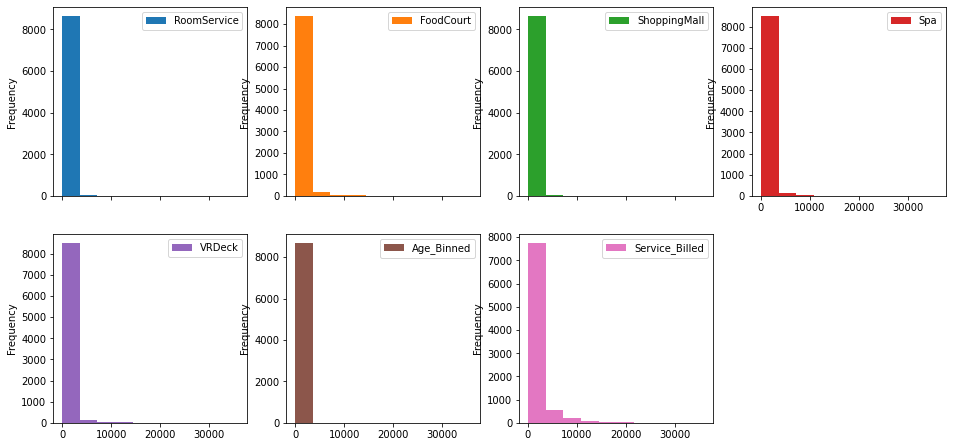

In [25]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

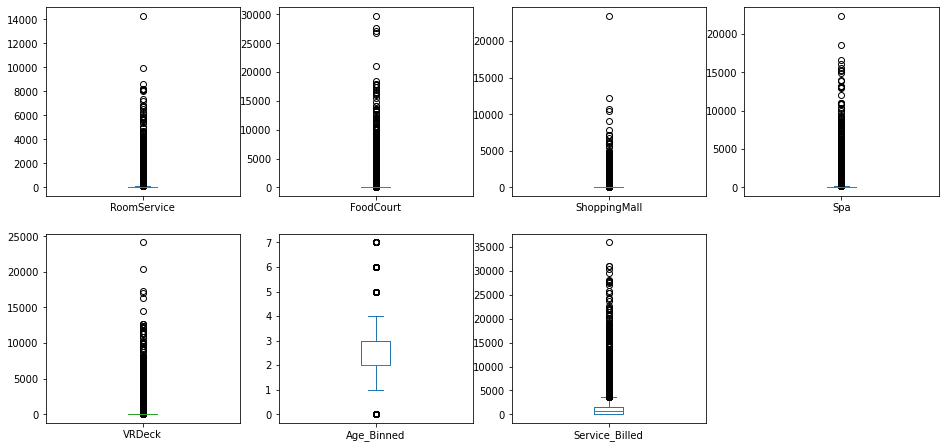

In [26]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

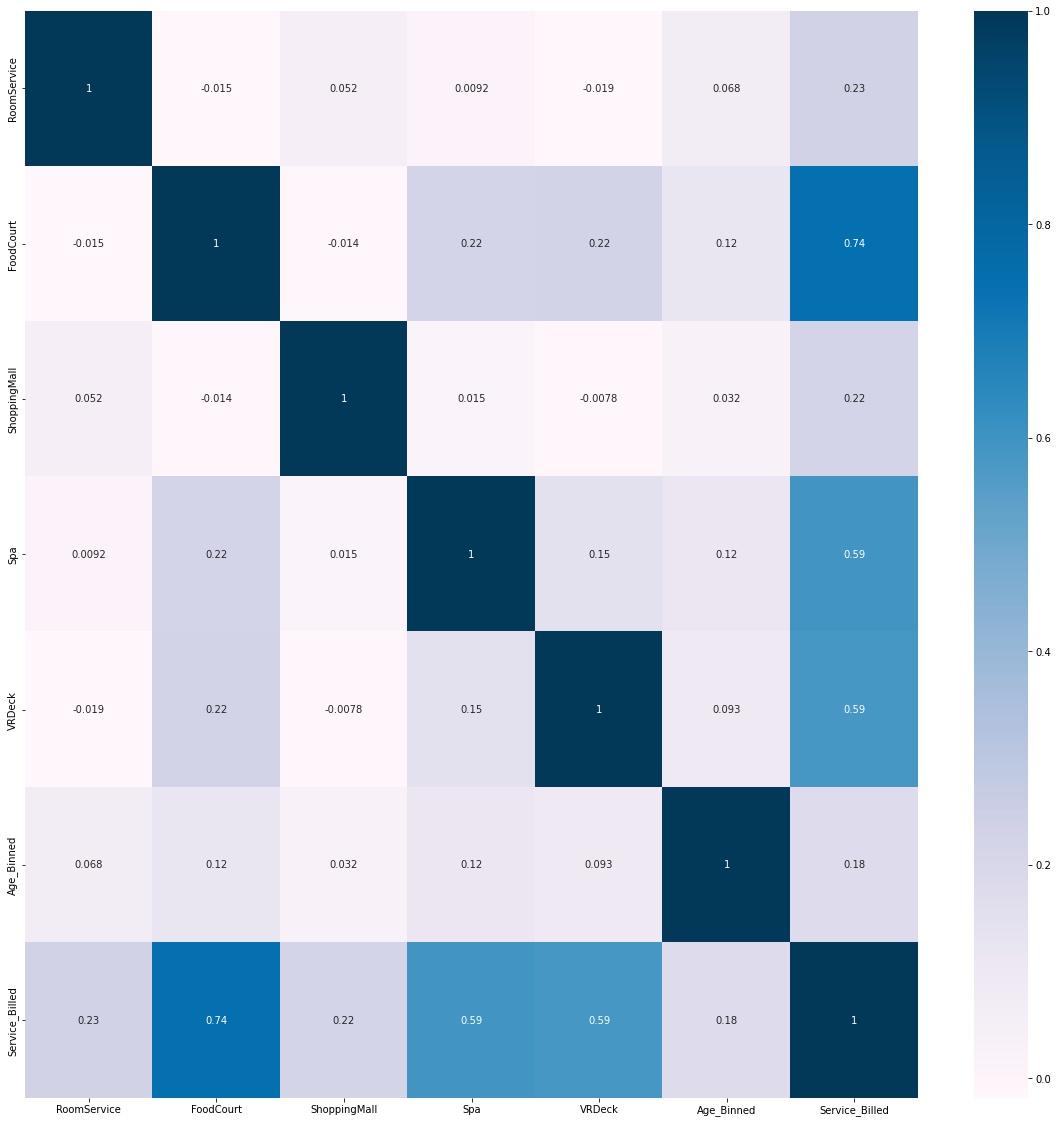

In [27]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [28]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [29]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [30]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['float','int']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    ('scaler', preprocessing.StandardScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 7
Number of categorical columns: 8
Total number of columns in the feature dataframe: 15


In [31]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
    ], remainder='passthrough')

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (8693, 15) to array_features_train.shape: (8693, 1848)


### 3.b) Training Data Balancing

In [32]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [33]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [34]:
# Finalize the training dataset for the modeling activities
label_encoder = preprocessing.LabelEncoder()
array_target_train = label_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (8693, 1848) array_target_train.shape: (8693,)


In [35]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [36]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [37]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=array_features_train.shape[1], output_param=NUM_CLASSES,
                    layer1_nodes=4096, layer2_nodes=2048, layer3_nodes=1024, layer4_nodes=1024, layer5_nodes=512,
                    layer1_dropout=0, layer2_dropout=0, layer3_dropout=0, layer4_dropout=0, layer5_dropout=0,
                    classifier_activation=CLASSIFIER_ACTIVATION,
                    loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    nn_model = keras.Sequential([
        keras.layers.Dense(layer1_nodes, input_shape=(input_param,), activation='relu'),
        keras.layers.Dropout(layer1_dropout),
        keras.layers.Dense(layer2_nodes, activation='relu'),
        keras.layers.Dropout(layer2_dropout),
        keras.layers.Dense(layer3_nodes, activation='relu'),
        keras.layers.Dropout(layer3_dropout),
        keras.layers.Dense(layer4_nodes, activation='relu'),
        keras.layers.Dropout(layer4_dropout),
        keras.layers.Dense(layer5_nodes, activation='relu'),
        keras.layers.Dropout(layer5_dropout),
        keras.layers.Dense(output_param, activation=classifier_activation)
    ])
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [38]:
# Initialize the default model and get a baseline result
start_time_module = datetime.now()
results = list()
iteration = 0
cv = RepeatedKFold(n_splits=N_FOLDS, n_repeats=N_ITERATIONS, random_state=RNG_SEED)
for train_ix, val_ix in cv.split(array_features_train):
    feature_train, feature_validation = array_features_train[train_ix], array_features_train[val_ix]
    target_train, target_validation = array_target_train[train_ix], array_target_train[val_ix]
    tf.keras.utils.set_random_seed(RNG_SEED)
    baseline_model = create_nn_model()
    baseline_model.fit(feature_train, target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=1)
    model_metric = baseline_model.evaluate(feature_validation, target_validation, verbose=0)[1]
    iteration = iteration + 1
    print('Score from iteration %d >>> %.4f' % (iteration, model_metric))
    results.append(model_metric)
validation_score = np.mean(results)
validation_variance = np.std(results)
print('Average model score from all iterations: %.4f (%.4f)' % (validation_score, validation_variance))
print('Total time for model fitting and cross validating:', (datetime.now() - start_time_module))

Epoch 1/10
218/218 [==============================] - 2s 3ms/step - loss: 0.4706 - accuracy: 0.7754
Epoch 2/10
218/218 [==============================] - 1s 3ms/step - loss: 0.3948 - accuracy: 0.8154
Epoch 3/10
218/218 [==============================] - 1s 4ms/step - loss: 0.3512 - accuracy: 0.8374
Epoch 4/10
218/218 [==============================] - 1s 3ms/step - loss: 0.2884 - accuracy: 0.8753
Epoch 5/10
218/218 [==============================] - 1s 3ms/step - loss: 0.2118 - accuracy: 0.9163
Epoch 6/10
218/218 [==============================] - 1s 3ms/step - loss: 0.1339 - accuracy: 0.9479
Epoch 7/10
218/218 [==============================] - 1s 3ms/step - loss: 0.0826 - accuracy: 0.9720
Epoch 8/10
218/218 [==============================] - 1s 3ms/step - loss: 0.0618 - accuracy: 0.9763
Epoch 9/10
218/218 [==============================] - 1s 3ms/step - loss: 0.0559 - accuracy: 0.9786
Epoch 10/10
218/218 [==============================] - 1s 3ms/step - loss: 0.0502 - accuracy: 0.9823

### 4.b) Algorithm Tuning

In [39]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [40]:
# Not applicable for this iteration of modeling

In [41]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [42]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [43]:
FINAL_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.00005)
tf.keras.utils.set_random_seed(RNG_SEED)
final_model = create_nn_model(opt_param=FINAL_OPTIMIZER)
final_model.fit(array_features_train, array_target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=1)
final_model.summary()

Epoch 1/10
272/272 [==============================] - 1s 3ms/step - loss: 0.4576 - accuracy: 0.7822
Epoch 2/10
272/272 [==============================] - 1s 3ms/step - loss: 0.3899 - accuracy: 0.8167
Epoch 3/10
272/272 [==============================] - 1s 3ms/step - loss: 0.3496 - accuracy: 0.8430
Epoch 4/10
272/272 [==============================] - 1s 3ms/step - loss: 0.2850 - accuracy: 0.8817
Epoch 5/10
272/272 [==============================] - 1s 3ms/step - loss: 0.1993 - accuracy: 0.9166
Epoch 6/10
272/272 [==============================] - 1s 3ms/step - loss: 0.1354 - accuracy: 0.9460
Epoch 7/10
272/272 [==============================] - 1s 3ms/step - loss: 0.0891 - accuracy: 0.9645
Epoch 8/10
272/272 [==============================] - 1s 3ms/step - loss: 0.0567 - accuracy: 0.9784
Epoch 9/10
272/272 [==============================] - 1s 3ms/step - loss: 0.0513 - accuracy: 0.9798
Epoch 10/10
272/272 [==============================] - 1s 3ms/step - loss: 0.0411 - accuracy: 0.9827

### 5.b) Load Test Dataset and Make Predictions

In [44]:
df_features_test = pd.read_csv(TEST_DATASET)

# Take a peek at the dataframe after import
print(df_features_test.head())

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e  19.0  False   
2     0019_01     Europa      True  C/0/S  55 Cancri e  31.0  False   
3     0021_01     Europa     False  C/1/S  TRAPPIST-1e  38.0  False   
4     0023_01      Earth     False  F/5/S  TRAPPIST-1e  20.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0          0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1          0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2          0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3          0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4         10.0        0.0         635.0     0.0     0.0   Brence Harperez  


In [45]:
id_column_name = df_features_test.columns[0]
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission[id_column_name] = df_features_test[id_column_name]
print(df_kaggle_submission.head())

  PassengerId
0     0013_01
1     0018_01
2     0019_01
3     0021_01
4     0023_01


In [46]:
# Break up the PassengerId attribute to get the grouping indicator
df_features_test['Group_Number'] = df_features_test['PassengerId'].apply(convert_group)
df_features_test['Grouped'] = df_features_test['Group_Number'].apply(grouping_test)

# Break up the Cabin attribute into three separate features
df_features_test['Cabin'].fillna('X/0/X', inplace=True)
df_features_test['Cabin'] = df_features_test['Cabin'].astype(str)
df_features_test['Cabin_1'] = df_features_test['Cabin'].apply(convert_cabin1)
df_features_test['Cabin_2'] = df_features_test['Cabin'].apply(convert_cabin2)
df_features_test['Cabin_3'] = df_features_test['Cabin'].apply(convert_cabin3)

# Fill in some missing fields with the most common values
df_features_test['HomePlanet'].fillna('Earth', inplace=True)
df_features_test['CryoSleep'].fillna('FALSE', inplace=True)
df_features_test['CryoSleep'] = df_features_test['CryoSleep'].astype(str)
df_features_test['Destination'].fillna('TRAPPIST-1e', inplace=True)

df_features_test['Age'].fillna(value=df_features_test['Age'].median(), inplace=True)
df_features_test['Age_Binned'] = est.transform(df_features_test['Age'].to_numpy().reshape(-1, 1))

df_features_test['VIP'].fillna('FALSE', inplace=True)
df_features_test['VIP'] = df_features_test['VIP'].astype(str)

df_features_test['RoomService'].fillna(0, inplace=True)
df_features_test['FoodCourt'].fillna(0, inplace=True)
df_features_test['ShoppingMall'].fillna(0, inplace=True)
df_features_test['Spa'].fillna(0, inplace=True)
df_features_test['VRDeck'].fillna(0, inplace=True)
df_features_test['Service_Billed'] = df_features_test['RoomService'] + \
                                     df_features_test['FoodCourt'] + \
                                     df_features_test['ShoppingMall'] + \
                                     df_features_test['Spa'] + \
                                     df_features_test['VRDeck']

df_features_test.drop(columns=[id_column_name,'Name','Cabin','Age','Group_Number'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

  HomePlanet CryoSleep  Destination    VIP  RoomService  FoodCourt  \
0      Earth      True  TRAPPIST-1e  False          0.0        0.0   
1      Earth     False  TRAPPIST-1e  False          0.0        9.0   
2     Europa      True  55 Cancri e  False          0.0        0.0   
3     Europa     False  TRAPPIST-1e  False          0.0     6652.0   
4      Earth     False  TRAPPIST-1e  False         10.0        0.0   

   ShoppingMall     Spa  VRDeck Grouped Cabin_1 Cabin_2 Cabin_3  Age_Binned  \
0           0.0     0.0     0.0      No       G       3       S         2.0   
1           0.0  2823.0     0.0      No       F       4       S         1.0   
2           0.0     0.0     0.0      No       C       0       S         3.0   
3           0.0   181.0   585.0      No       C       1       S         3.0   
4         635.0     0.0     0.0      No       F       5       S         2.0   

   Service_Billed  
0             0.0  
1          2832.0  
2             0.0  
3          7418.0  
4   

In [47]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (4277, 15) to array_features_test.shape: (4277, 1848)


In [48]:
# Make batched predictions
test_probabilities =  final_model.predict(array_features_test)
test_predictions =  (test_probabilities > 0.5).astype(int).ravel()
print(test_predictions)

134/134 [==============================] - 0s 2ms/step
[1 0 1 ... 1 1 1]


In [49]:
df_sample_submission = pd.read_csv(SUBMISSION_TEMPLATE)
df_sample_submission.drop(columns=[id_column_name], inplace=True)
submission_header = list(df_sample_submission.columns)[0]
print(submission_header)

Transported


In [50]:
df_kaggle_submission[submission_header] = test_predictions
df_kaggle_submission[submission_header] = df_kaggle_submission[submission_header].astype(bool)
print(df_kaggle_submission.head())

  PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01        False


In [51]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = SUBMISSION_FILE + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_tensorflow_20221219-1756.csv


In [52]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [53]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:01:11.059799
